In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re


In [2]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 

In [4]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return k_best_bids_and_asks

In [5]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [6]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [7]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [8]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if record.shape!=(2,2,5):
        raise ValueError('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [9]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [10]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [11]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [12]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [13]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [14]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [15]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 5)
(99, 10)


# parameters calculation functions

In [16]:
## DONT USE VVV
def get_order_inbalance_interval_bad(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        for j in range(interval):
            #print(np.sum(record[i:i+interval,0,1]))
            result[i]+=math.log((1e-10+np.sum(record[i+j][0][1]))/(1e-10+np.sum(record[i+j][1][1]))) # ln(bid size/ask size)
    return result
###DONT USE AAAA

def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [17]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[1504.,  466., 2115., 8682.,  667.],
       [3396.,  701., 2615., 8682.,  501.],
       [3582.,  701., 2115., 8682., 1001.],
       [3323., 3262., 3146., 9713., 2032.]])

In [18]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [19]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.07873018, -0.06199148,  0.19954649, -0.03546426,  0.01784012,
       -0.08710945, -0.2216419 , -0.25986639])

In [20]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter+1))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [21]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [22]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [23]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [24]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [25]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [26]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [27]:
1e7

10000000.0

# HEATMAP

In [28]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


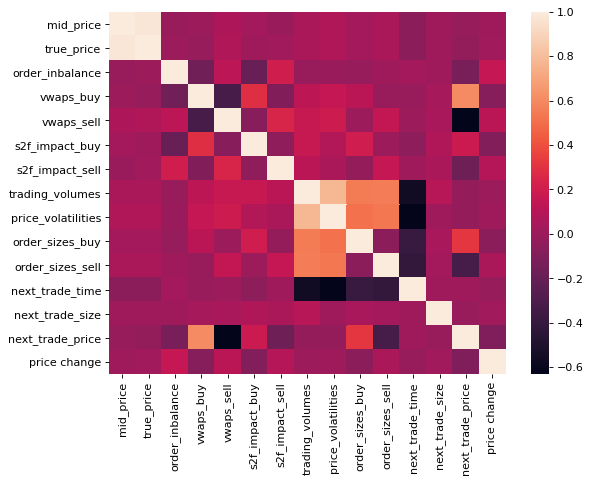

In [29]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [30]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier



In [31]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [32]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [33]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [34]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [152]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [147]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False, new=True): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [38]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [39]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [40]:
def logistic_regr(X, y, split_percent, epsilon=1e-6, comp_id=1, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [41]:
def decision_tree(X, y, split_percent, epsilon, comp_id,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [42]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [43]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.000001

In [60]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))




851.5752484506002
decision_tree
Coefficient impact:
order_inbalance   0.13929592838855687
vwaps_buy   0.11231448227822355
vwaps_sell   0.04469679848602815
s2f_impact_buy   0.048420560927732344
s2f_impact_sell   0.018768709336298917
trading_volumes   0.05604536426463246
price_volatilities   0.013816926702494474
vwaps_order_sizes_buy   0.014209815386705541
vwaps_order_sizes_sell   0.03992143518756199
s2f_order_sizes_buy   0.03522399168924559
s2f_order_sizes_sell   0.035179137550745976
next_trade_time   0.12780628312357192
next_trade_size   0.16304941572596718
next_trade_price   0.15125115095223501
score:  0.5052631578947369
log reg
Coefficient impact:
order_inbalance   -0.7062669469923076
vwaps_buy   -1.0035278915239507
vwaps_sell   1.3474720034957914
s2f_impact_buy   -0.061930117548838676
s2f_impact_sell   0.23461187211707532
trading_volumes   0.205907501947982
price_volatilities   -0.3065772153293015
vwaps_order_sizes_buy   0.025394912633929304
vwaps_order_sizes_sell   0.65187975420032